# objectClassification

This script implements a simple object classification pipeline using a 
two-layer MLP in PyTorch. It loads 128-dimensional feature vectors for 
10 object categories, trains the classifier, evaluates accuracy, and 
visualizes the results with a confusion matrix.

## Workflow:
1. Load feature vectors from CSV files (180 samples per object).
2. Split into training (126 samples) and test (54 samples) sets.
3. Wrap data with a custom PyTorch Dataset (objClsf).
4. Train an MLP (128 → 32 → 10) with ReLU activation and Softmax output.
5. Evaluate on the test set and print accuracy.
6. (Optional) Plot confusion matrix for detailed performance.

## Dependencies:
    torch, torchvision, numpy, pandas, matplotlib, scikit-learn


In [1]:
import pandas as pd
import torch
import numpy as np
import csv
import random
import os

import sys

from torch.autograd import Variable
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

In [ ]:
# Mapping from label ID to object name
objList = {0: "cherry", 1:"eraser", 2:"lemon", 3:"lemonPiece", 4:"lightbulb", 5:"pear", 6:"pinecone", 7:"strawberry", 8:"tapeDispenser", 9:"yuanbao"}


# Custom Dataset for Object Classification
class objClsf(Dataset):
    def __init__(self, data):
        super().__init__()
        self.labelDict = {"cherry":0, "eraser":1, "lemon":2, "lemonPiece":3, "lightbulb":4, "pear":5, "pinecone":6, "strawberry":7, "tapeDispenser":8, "yuanbao":9}
        random.shuffle(data)
        self.data = data

    def __getitem__(self, index):
        d = self.data[index][0]
        d = torch.tensor(d, dtype=torch.float32) /229.0
        return d, self.labelDict[self.data[index][1]]
        
    def __len__(self):
        return len(self.data)

In [ ]:
# MLP Classifier
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.sq = nn.Sequential()
        self.fc1 = nn.Linear(128,32)
        self.fc2 = nn.Linear(32,10)
        self.sm = nn.Softmax(dim=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.relu(self.fc1((x)))
        out = self.sm(self.fc2(out))
        return out

# Training Loop
def Train(epochs, trainLoader, model, device, learningRate):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    model.to(device)
    correct = 0
    total = 0
    for e in range(epochs):
        runningloss = 0
        correct = 0
        total = 0
        for i, (data, label) in enumerate(trainLoader):
            optimizer.zero_grad()
            data = data.to(device)
            label = label.to(device)
            out = model(data)
            _, pre = torch.max(out, 1)
            total += label.size(0)
            correct += (pre == label).sum().item()
            loss = criterion(out, label)
            loss.backward()
            optimizer.step()
            runningloss += loss.data
            if (i+1)%10 == 0:
                print('epoch: {}, batch: {}, loss:{}'.format(e+1, i+1, runningloss/(i+1)))
        print('Accuracy: {}'.format(correct/total))

    # To save the trained model, uncomment:    
    # torch.save(model, 'data/objCls/objCls_10_objects.pth')

# Evaluation Loop
def Test(testLoader, model, device):
    model.to(device)
    torch.no_grad()
    correct = 0
    total = 0
    preL = []
    labelL = []
    for (data, label) in testLoader:   
        data = data.to(device)
        label = label.to(device)
        out = model(data)
        _, pre = torch.max(out, 1)
        total += label.size(0)
        correct += (pre == label).sum().item()
        preL += list(pre.cpu().numpy())
        labelL += list(label.cpu().numpy())
    print('Accuracy: {}'.format(correct/total))
    return preL, labelL

In [ ]:
# Data Preparation
test = []
train = []
valid = []
data = []

# Load 180 samples per class, split into train (126) / test (54)
for i in range(10):
    curr_data = []
    with open(f"data/objCls/{objList[i]}.csv", "r", newline="") as file:
        for j in range(180):
            curr_data.append([eval(file.readline()), objList[i], str(j)])

        random.shuffle(curr_data)
        test += curr_data[:54]
        train += curr_data[54:]
        data += curr_data



In [ ]:
# Train the model
trainDataset = objClsf(train)    
train_loader = DataLoader(trainDataset, batch_size=16, shuffle=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = MLP()
Train(10, train_loader, model, device, 0.01)

epoch: 1, batch: 10, loss:2.3028903007507324
epoch: 1, batch: 20, loss:2.3019654750823975
epoch: 1, batch: 30, loss:2.299384593963623
epoch: 1, batch: 40, loss:2.295032501220703
epoch: 1, batch: 50, loss:2.289425849914551
epoch: 1, batch: 60, loss:2.280324935913086
epoch: 1, batch: 70, loss:2.2681586742401123
Accuracy: 0.17936507936507937
epoch: 2, batch: 10, loss:2.124046802520752
epoch: 2, batch: 20, loss:2.114375591278076
epoch: 2, batch: 30, loss:2.1059744358062744
epoch: 2, batch: 40, loss:2.0848891735076904
epoch: 2, batch: 50, loss:2.080540895462036
epoch: 2, batch: 60, loss:2.0641250610351562
epoch: 2, batch: 70, loss:2.0508553981781006
Accuracy: 0.4634920634920635
epoch: 3, batch: 10, loss:1.8855713605880737
epoch: 3, batch: 20, loss:1.8699045181274414
epoch: 3, batch: 30, loss:1.8721356391906738
epoch: 3, batch: 40, loss:1.8699325323104858
epoch: 3, batch: 50, loss:1.8492416143417358
epoch: 3, batch: 60, loss:1.840891718864441
epoch: 3, batch: 70, loss:1.8322837352752686
Accu

In [ ]:
# Test the model (using pretrained .pth)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
testDataset =  objClsf(test)    
test_loader = DataLoader(testDataset, batch_size=16, shuffle= True)
model = torch.load('data/objCls/objCls_10_objects.pth')
res = Test(test_loader, model, device)

Accuracy: 0.9962962962962963


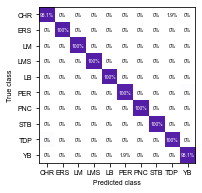

In [ ]:
# Confusion Matrix Plot

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 7

colors = ["white", plt.cm.get_cmap('plasma_r')(0.9)]  
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)

# labelNameList  = ["cherry", "eraser", "lemon", "lemonPiece", "lightbulb", "pear", "pinecone", "strawberry", "tapeDispenser", "yuanbao"]
labelNameList = ["CHR", "ERS", "LM", "LMS", "LB", "PER", "PNC", "STB", "TDP", "YB"]
preL, labelL = res
confusion = confusion_matrix(preL, labelL)
confusion_plot = confusion.copy()
confusion_plot = confusion_plot / confusion_plot.sum(axis=1, keepdims=True)  # Normalize the confusion matrix
plt.figure(figsize=(3,2.7))
plt.imshow(confusion_plot, cmap=cmap, alpha=0.9)

indices = range(len(confusion))
plt.xticks(indices, labelNameList)
plt.yticks(indices, labelNameList)
plt.xlabel('Predicted class')
plt.ylabel('True class')

def num_Round(num):
    a = round(num,1)
    if str(a)[-1] == "0":
        a = int(num)
    return a

percentage = []
for i in range(len(confusion)):
    for j in range(len(confusion[i])):
            int_num = confusion[i][j]

for first_index in range(len(confusion)):
    for second_index in range(len(confusion[first_index])):
        plt.text(first_index, second_index, str(num_Round(confusion[first_index][second_index]/54*100))+'%', ha="center", va="center", color="white" if confusion[first_index][second_index]>30 else "black", fontsize=5)

plt.tight_layout()
plt.show()